# Preprocess Data

In [4]:
# converting image to ela image
from glob import glob 
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import os 

def convert_to_ela_image(image_path, quality=90):
    """Converts an image to an ELA image.
    :param image_path: Path to the image
    :param quality: Quality of the image to be saved
    :return: ELA image
    """
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path)
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

In [5]:
# all iamges
images = glob('../input/casia-dataset/CASIA2/*/*.jpg')
print('Total images: ', len(images))

Total images:  9418


# Converting to ELA images

In [6]:
# converting images to ela images
for image in tqdm(images):
    # converting image to ela image
    ela_image = convert_to_ela_image(image)
    # creating a new directory for ela images
    if not os.path.exists('/CASIA2_ELA'):
        os.mkdir('/CASIA2_ELA')
    ela_image.save('/CASIA2_ELA/' + image.split('/')[-1])

100%|██████████| 9418/9418 [06:36<00:00, 23.75it/s]


# Importing Fastai 

In [7]:
from fastai.vision.all import * 

In [8]:
path = Path('/CASIA2_ELA')
Path.BASE_PATH = path
path.ls()

(#9418) [Path('Tp_D_NRN_M_B_art00045_pla00088_10745.jpg'),Path('Au_nat_30257.jpg'),Path('Au_ind_00027.jpg'),Path('Au_pla_30366.jpg'),Path('Au_sec_10105.jpg'),Path('Tp_D_NRN_S_N_nat10159_ani00058_12051.jpg'),Path('Tp_D_NRN_M_N_sec00064_cha00070_11408.jpg'),Path('Au_art_30675.jpg'),Path('Au_sec_30351.jpg'),Path('Au_arc_30220.jpg')...]

# DataBloack and DataLoader

In [9]:
# function to get labels
def get_label(x): return x.name.split('_')[0]

# creating a datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=get_image_files,
                        splitter=RandomSplitter(valid_pct=0.2, seed=42),
                        get_y=get_label,
                        item_tfms=Resize(224))
                    
# creating a dataloader
dls = dblock.dataloaders(path)

# Resnet18

In [10]:
# creating a vision learner
learn = vision_learner(dls, resnet18, metrics=accuracy)

# training the model
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.535131,0.277690,0.898566,01:20


epoch,train_loss,valid_loss,accuracy,time
0,0.274627,0.159910,0.936803,01:10
1,0.175998,0.148220,0.942645,01:11
2,0.109525,0.109075,0.959108,01:10
3,0.072269,0.103828,0.962825,01:10


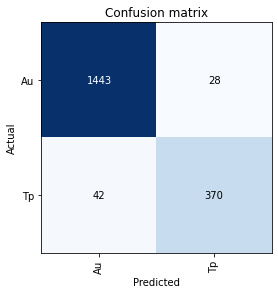

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()